This is my code for the Module 2 Project. The questions have been copied and pasted below:

Task: Create code using python xarray to organize and reduce climate data.

Task: Create code using python xarray to organize and reduce climate data. The goal of this analysis will be to detect global atmospheric circulation patterns (or teleconnections) associated with extreme daily precipitation in a certain part of the globe. You will

(1) Use the precipitation output of ERA-5 to compute a time series of daily precipitation at a given point closest to a city of your choosing. Choose a box of 5 x 5 deg lat-lon values over the grid box closest to the city you are examining. Save this data. Use a period of at least 10 years.

I will be choosing Valparaiso, Indiana because it is my hometown. The meteorology is interesting here because it is just south of Lake Michigan, so we get quite a bit of convection forming off lake-breeze boundaries. 

(2) Determine the 95% values of daily precipitation for the data created in (1). Plot a cumulative distribution function of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

(3) Create a map of the composite mean precipitation on the 95% days identified in (2) over the continental USA, and a map of the anomaly of precipitation from the 1981-2010 mean. This field should be plotted on a Cartopy map centered at your city with a 40 x 40 degree lat-lon range.

In [2]:
# Import necessary python packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cf
import dask
from dask.distributed import Client, progress
from dask.diagnostics import ProgressBar

In [3]:
# Set-up a temporary dask directory and open a dask client
dask.config.set(temporary_directory='/tmp/mgraber2-dask')
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 72.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37201,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 72.00 GiB
Comm: tcp://127.0.0.1:37015,Total threads: 1
Dashboard: http://127.0.0.1:39457/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:46859,


(1) Use the precipitation output of ERA-5 to compute a time series of daily precipitation at a given point closest to a city of your choosing. Choose a box of 5 x 5 deg lat-lon values over the grid box closest to the city you are examining. Save this data. Use a period of at least 10 years.

Valparaiso coordinates: latitude: 38-43 degrees north, longitude: 270-275 degrees West 

In [37]:
# Open ARCO ERA5 and slice for 1990 to 2020 and chunk for lazy computation
import gcsfs
fs = gcsfs.GCSFileSystem(token="anon")

ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={'time': 100},
    storage_options={'token': 'anon'},
)

ds = ds.sel(time=slice("1990", "2020"))

ds

/tmp/ipykernel_1256282/3868533234.py:5: UserWarning: Failed to load chunk manager entrypoint dask due to No module named 'xarray.core.daskmanager'. Skipping.
  ds = xr.open_zarr(


<xarray.Dataset> Size: 755TB
Dimensions:                                                          (
                                                                      time: 271752,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 2MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 1TB dask.array<chunksize=(72, 721, 1440), meta=np.ndarray>
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-09-25 01:56:39.462148+00:00
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-19

In [6]:
# Slice for Valparaiso's coordinates
# Average the lat-lon coordinates to get a time series
# Resample the time for daily precip and compute
ds_slice = ds['total_precipitation'].sel(latitude = 41.47,
                                          longitude = 360-87.06, method='nearest')

# Convert from hourly precipitation to daily precipitation
ds_daily = ds_slice.resample(time='1D').sum()

# Compute the lazy computation
Valparaiso_precip = ds_daily.compute()

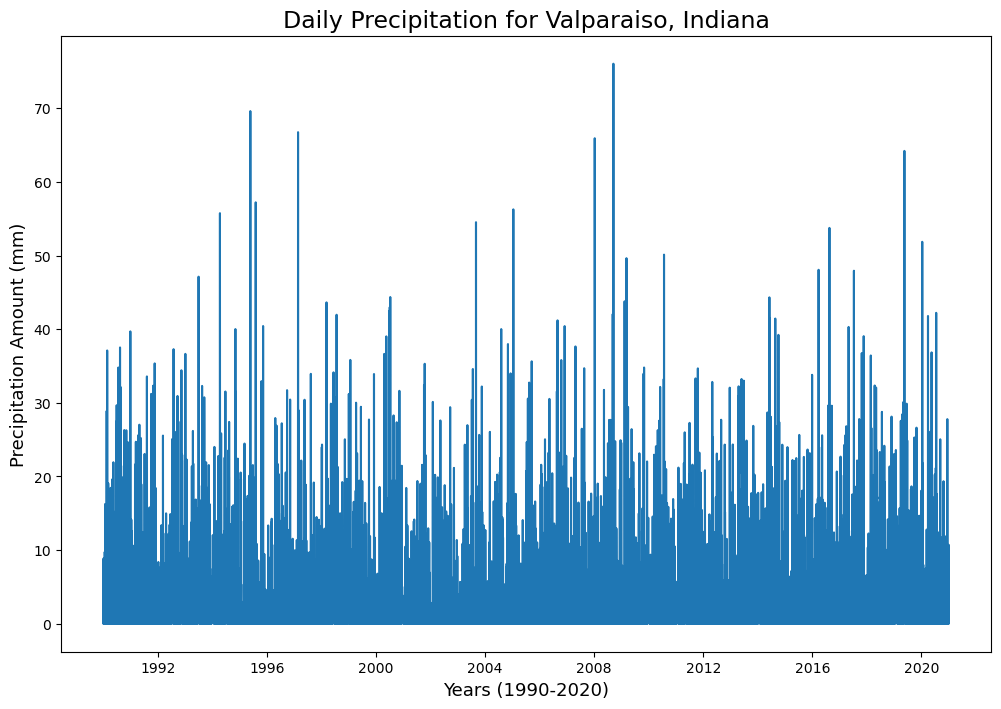

In [14]:
# Plot the figure and convert from m to mm. 
plt.figure(figsize=(12,8))
(Valparaiso_precip*1000).plot()
plt.xlabel('Years (1990-2020)', fontsize=13)
plt.ylabel('Precipitation Amount (mm)', fontsize=13)
plt.title('Daily Precipitation for Valparaiso, Indiana', fontsize=17)
plt.show()

In [18]:
# Slice a box around Valparaiso
ds_box = ds['total_precipitation'].sel(latitude = slice(43, 38),
                                          longitude = slice(270, 275))
# Average the time dimension for days
ds_daily_box = ds_box.resample(time='1D').sum()

In [22]:
# Save the dataset as a netcdf
ds_daily_box.to_netcdf("Valparaiso_gridbox_precip.nc")

/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 9.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [23]:
# Compute the mean precipitation
# Compute the lazy computation
# Save the timeseries dataset as a netcdf
ds_box_series = ds_daily_box.mean(dim=['latitude','longitude'])
Valparaiso_5x5_precip = ds_box_series.compute()
Valparaiso_5x5_precip.to_netcdf("Valparaiso_mean_precip.nc")

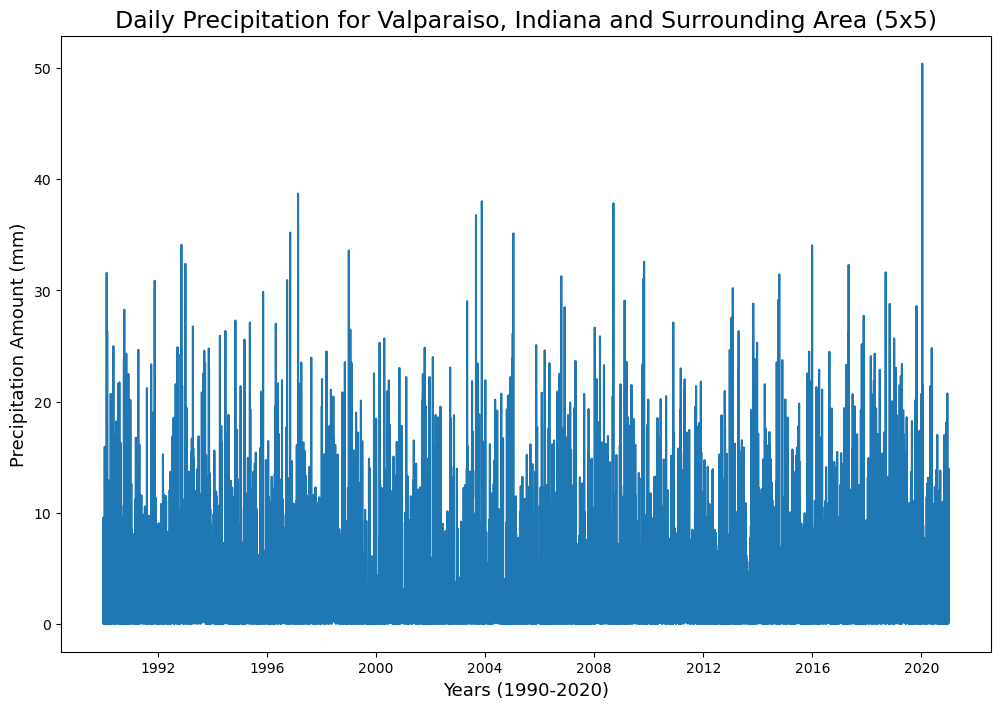

In [26]:
# Plot the figure and convert from m to mm. 
plt.figure(figsize=(12,8))
(Valparaiso_5x5_precip*1000).plot()
plt.xlabel('Years (1990-2020)', fontsize=13)
plt.ylabel('Precipitation Amount (mm)', fontsize=13)
plt.title('Daily Precipitation for Valparaiso, Indiana and Surrounding Area (5x5)', fontsize=17)
plt.show()

(2) Determine the 95% values of daily precipitation for the data created in (1). Plot a cumulative distribution function of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

In [17]:
# The 95 percentile of values in the 5x5 box
percentile_95 = (Valparaiso_5x5_precip*1000).quantile(.95)
percentile_95

<xarray.Dataset> Size: 16B
Dimensions:              ()
Coordinates:
    quantile             float64 8B 0.95
Data variables:
    total_precipitation  float64 8B 13.15

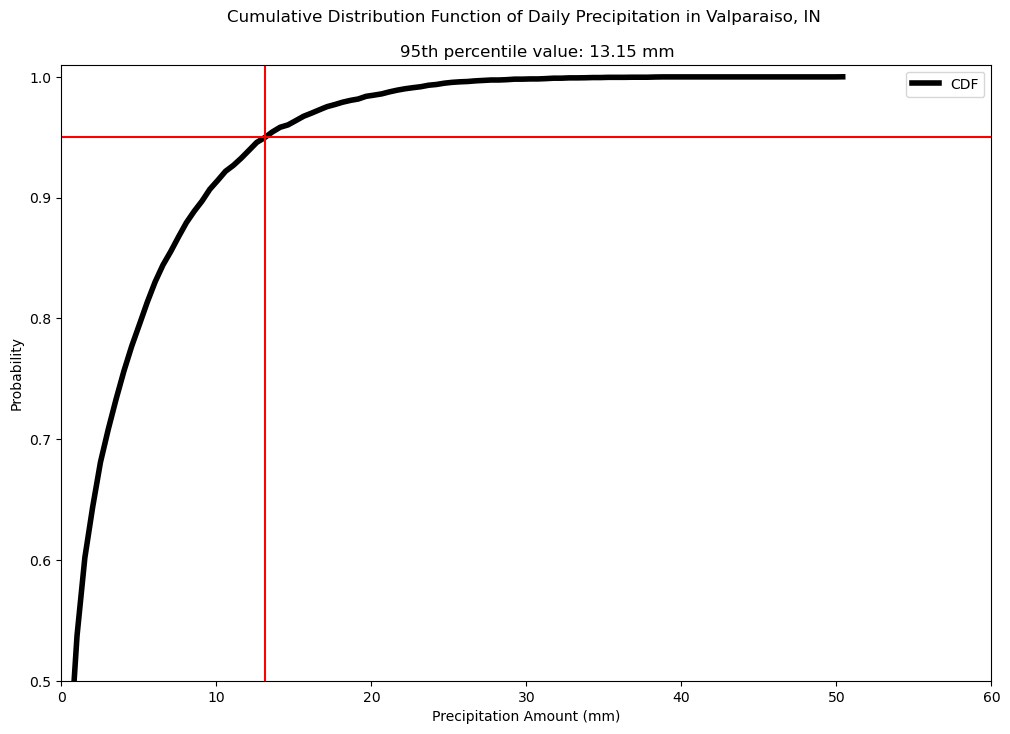

In [42]:
# Calculate the cumulative density function for the Valparaiso 5x5 grid-box daily precipitation
# Label the 95th percentile on the plot
count, bins_count = np.histogram((Valparaiso_5x5_precip*1000).dropna('time'), bins=100)
pdf = count / sum(count)  # Finding the PDF of the histogram using count values
cdf = np.cumsum(pdf)
  
plt.figure(figsize=(12,8))
plt.plot(bins_count[1:], cdf, label="CDF", color='k', linewidth=4)
plt.xlabel('Precipitation Amount (mm)')
plt.xlim(0,60)
plt.ylim(.5, 1.01)
plt.vlines(percentile_95, .5, 1.01, color='r')
plt.hlines(.95, 0, 60, color='r')
plt.ylabel('Probability')
plt.title("""Cumulative Distribution Function of Daily Precipitation in Valparaiso, IN \n
    95th percentile value: {} mm""".format((np.round(percentile_95,2)).values))
plt.legend()

(3) Create a map of the composite mean precipitation on the 95% days identified in (2) over the continental USA, and a map of the anomaly of precipitation from the 1981-2010 mean. This field should be plotted on a Cartopy map centered at your city with a 40 x 40 degree lat-lon range.

In [12]:
# Load in the climatology given by Steve and load in the Valparaiso gridbox time series in case you had to reset the notebook
ds_climo = xr.open_dataset('ERA-5_total_precipitation_monthly-1981-2020.nc')
Valparaiso_5x5_precip = xr.open_dataset('Valparaiso_mean_precip.nc')

In [20]:
# Extract the precipitation variable and multiply by 1000 to convert to mm
Precipitation = Valparaiso_5x5_precip['total_precipitation']
Precipitation = Precipitation*1000

In [24]:
# Extracts the days in which the precip is at least the 95th percentile value (13.15 mm)
Valparaiso_severe = Precipitation[Precipitation >= 13.15]

In [47]:
# Extract the dates contained in Valparaiso_severe
# Extract a 40x40 lat-lon range that reflects nearly the entire CONUS
# Get the start and end of each day in Valparaiso_severe
dates = pd.to_datetime(Valparaiso_severe['time'].values)
time_mask = ds['time'].dt.floor('D').isin(dates)

ds_CONUS = ds['total_precipitation'].sel(time = time_mask, latitude = slice(60, 20),
                                          longitude = slice(245, 285))
# Now resample only within the selected dates
ds_CONUS_daily = ds_CONUS.groupby(ds_CONUS['time'].dt.floor('D')).sum()

# Rename the new dimension
ds_CONUS_daily = ds_CONUS_daily.rename({'floor':'time'})

In [49]:
# Compute the values on the days that meet the 95 percentile in Valparaiso
# Make a composite map
# Multiply by 1000 to convert from m to mm
ds_CONUS_daily = ds_CONUS_daily.compute()
ds_95_comp = ds_CONUS_daily.mean(axis=0)
ds_95_comp = ds_95_comp*1000

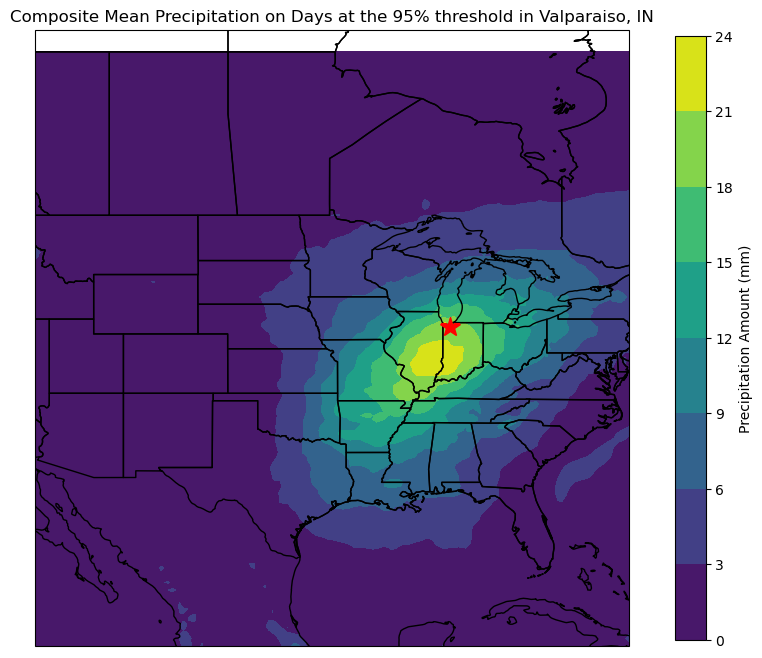

In [66]:
figure = plt.figure(figsize=(12,8))
ax = figure.add_subplot(1,1,1, projection = crs.PlateCarree())
ax.set_extent([245, 285, 20, 60])
lons = ds_95_comp.longitude
lats = ds_95_comp.latitude
plt.contourf(lons, lats, ds_95_comp, 
    cmap='viridis', transform=crs.PlateCarree())
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.STATES)

# Plot a star at Valparaiso
ax.plot(272.94, 41.47,
        marker='*', color='red', markersize=15,
        transform=crs.PlateCarree())  # important for lat/lon coordinates

plt.colorbar(ax=ax, shrink=.98, label='Precipitation Amount (mm)')
plt.title("""Composite Mean Precipitation on Days at the 95% threshold in Valparaiso, IN""")
plt.show()

In [71]:
# Average the 1990-2020 climatology over the time dimension to get the long-term mean
# Compute the anomalies for the 95% of days at Valparaiso
# Multiply anomalies by 1000 to convert to mm
# Convert anomalies to a dataarray
# Convert anomalies to a 2D composite array
ds_climo_comp = ds_climo.mean(dim="valid_time")
anomalies = ds_CONUS_daily - ds_climo_comp
anomalies = anomalies*1000
anomalies = anomalies['tp']
anomalies = anomalies.mean(axis=0)

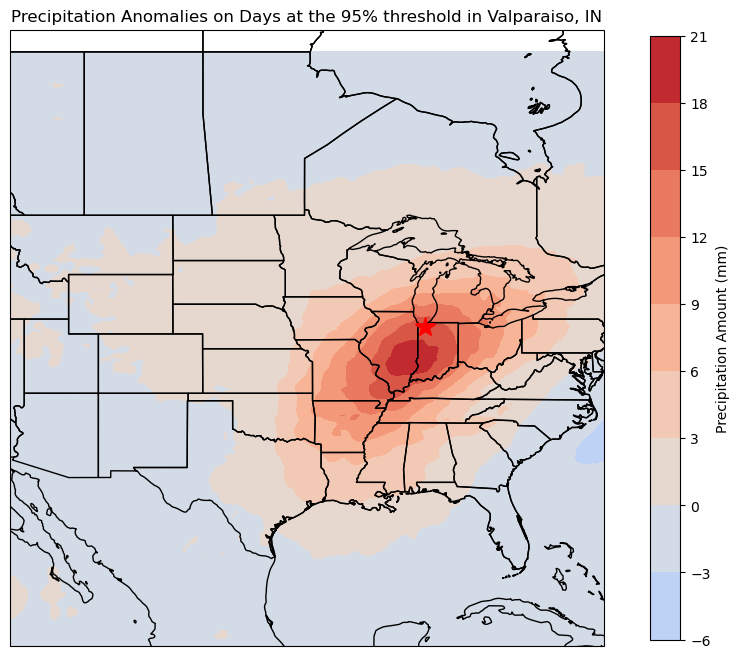

In [84]:
# Plot the anomalies on the same map as the composite
figure = plt.figure(figsize=(12,8))
ax = figure.add_subplot(1,1,1, projection = crs.PlateCarree())
ax.set_extent([245, 285, 20, 60])
lons = anomalies.longitude
lats = anomalies.latitude
plt.contourf(lons, lats, anomalies, 
    cmap='coolwarm', transform=crs.PlateCarree(), vmin = -21, vmax = 21)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.STATES)

# Plot a star at Valparaiso
ax.plot(272.94, 41.47,
        marker='*', color='red', markersize=15,
        transform=crs.PlateCarree())  # important for lat/lon coordinates

plt.colorbar(ax=ax, shrink=.98, label='Precipitation Amount (mm)')
plt.title("""Precipitation Anomalies on Days at the 95% threshold in Valparaiso, IN""")
plt.show()

In [ ]:
#### Close dask
client.close()